#  1.Introduction
## 1.1 background
Toronto ,London and New York are among famous tourist destinations in the world. They are diverse in many ways. All are multicultural as well as the financial hubs of their respective countries. We want to know how much they are similar or dissimilar in aspects from a tourist point of view regarding food, accommodation, beautiful places, and many more.
Tourism industry is important for the benefits it brings and due to its role as a commercial activity that creates demand and growth for many more industries. Tourism not only contributes towards more economic activities but also generates more employment, revenues and play a significant role in development. Many countries such as Turkey, France and Italy depend heavily on tourism industry for their expanses. 
## 1.2 interest
Knowing what makes tourists choose their travel destination is crucial information for anyone working in the travel business. Therefore, for anyone who relies on tourists and tourism, understanding the consumer behavior is essential. In this project I will focus on venues such as restaurants, hotels, parks, cafes, cinemas and so on in London, Toronto and New York and cluster their neighborhoods in order to understand the similarities and differences between these cities. 
Therefor the target audience would be tourists and travel agencies. Tourists can explore neighborhoods in each city and decide which city they prefer to visit or if they have been to one of these cities before and enjoyed their visit, they can select a similar city to travel next time. Travel agencies also can recommend destinations to their customers based on customers’ experience and similarity and dissimilarity between different cities.
# 2.Data acquisition and cleaning

This project will analyze venues of the city of Toronto, New York and London.
The data below will be used for this analysis.

## 2.1  Boroughs and neighborhoods
### 2.1.1 London:
London has in total 32 boroughs. To explore, analyze and segment neighborhoods, longitude and latitude of each neighborhood and borough will be added.
This dataset exists for free on the web. I used this website: https://skgrange.github.io/www/data/london_sport.json

### 2.1.2 New York:
New York has a total of 5 boroughs and 306 neighborhoods. In order to segment the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the latitude and longitude coordinates of each neighborhood.
Luckily, this dataset exists for free on the web. Here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

### 2.1.3 Toronto:
For Toronto, I used the table in Wikipedia for postal code and borough of each neighborhood. (link to the Wikipedia page: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M ) and for the longitude and latitude of each neighborhood I used a csv file available in: : http://cocl.us/Geospatial_data

## 2.2 Foursquare API
in order to explore neighborhoods and cluster them we need to search for venues in each neighborhood. Foursquare API(utilized via the Request library in Python) permits to provide venues information for each neighborhood.

## 2.3 cleaning Dataframes and calling Foursquare API 
let's download all the dependencies that we will need.
For convenience, all the libraries are presented at the beginning

In [1]:
import pandas as pd
import numpy as np
!pip install lxml
import json # library to handle JSON files

!pip install geopy 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
import folium # map rendering library

print('Libraries imported.')

     |████████████████████████████████| 93 kB 2.7 MB/s  eta 0:00:01
Libraries imported.


In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
radius=500
LIMIT=100
LIMITlondon=200
radiuslondon=700

## 2.3.1 London Dataframe:
here I used the json file mentioned earlier and extracted neighborhood name,latititude and longitude into a pandas dataframe.

In [12]:
import urllib.request
url='https://skgrange.github.io/www/data/london_sport.json'

with urllib.request.urlopen(url) as json_data:
    londn_data = json.loads(json_data.read().decode())
    
column_names_london = ['Neighbprhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
london_data = pd.DataFrame(columns=column_names_london)


In [13]:
for data in londn_data['features']:
    #print(data)
    for i in range(0,5):
        neighborhood =  data['properties']['name'] 
        neighborhood=str(str(neighborhood)+str(i))
    
        
        neighborhood_latlon = data['geometry']['coordinates'][0][i]
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        london_data = london_data.append({'Neighborhood': neighborhood,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [14]:
london_data=london_data.drop('Neighbprhood',axis=1)
calls=['Neighborhood','Latitude','Longitude']
london_data=london_data[calls]
london_data.head()

,Neighborhood,Latitude,Longitude
0,Bromley0,51.442884,0.031639
1,Bromley1,51.440465,0.041526
2,Bromley2,51.423211,0.063333
3,Bromley3,51.431508,0.076946
4,Bromley4,51.413598,0.109226


In [8]:
map_london = folium.Map(location=[51.5074, 0.1278], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(london_data['Latitude'], london_data['Longitude'], london_data['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

now I will explore each neighborhood and  get the top 100 venues in each neighborhood that are within a radius of 500 meters using Foursquare API.

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
london_venues = getNearbyVenues(names=london_data['Neighborhood'],
                                   latitudes=london_data['Latitude'],
                                   longitudes=london_data['Longitude']
                                  ) 
london_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bromley0,51.442884,0.031639,Horn Park,51.442686,0.026776,Park
1,Bromley0,51.442884,0.031639,Mottingham Farm Riding Centre,51.439569,0.035346,Stables
2,Bromley1,51.440465,0.041526,RJ Landscapes,51.441462,0.041531,Construction & Landscaping
3,Bromley1,51.440465,0.041526,U-Keep Building & Construction Ltd,51.442014,0.043359,Construction & Landscaping
4,Bromley1,51.440465,0.041526,Eric Liddell Sports Centre,51.438059,0.039675,Gym / Fitness Center


In [17]:
london_venues['City']='London'
london_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,City
0,Bromley0,51.442884,0.031639,Horn Park,51.442686,0.026776,Park,London
1,Bromley0,51.442884,0.031639,Mottingham Farm Riding Centre,51.439569,0.035346,Stables,London
2,Bromley1,51.440465,0.041526,RJ Landscapes,51.441462,0.041531,Construction & Landscaping,London
3,Bromley1,51.440465,0.041526,U-Keep Building & Construction Ltd,51.442014,0.043359,Construction & Landscaping,London
4,Bromley1,51.440465,0.041526,Eric Liddell Sports Centre,51.438059,0.039675,Gym / Fitness Center,London


# Toronto neighborhoods:

In [18]:
d=pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
df=d[0]
df.replace('Not assigned',np.nan,inplace=True)
df.dropna(subset=['Borough'],axis=0,inplace=True)
df=df.reset_index(drop=True)
csvfile='http://cocl.us/Geospatial_data'
dff=pd.read_csv(csvfile)
toronto_data = pd.merge(df, dff, on='Postal Code')
toronto_data=toronto_data.rename(columns={"Neighbourhood": "Neighborhood"})
toronto_data


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In [19]:
print('The Toronto has {} boroughs and {} neighborhoods.'.format(
        len(toronto_data['Borough'].unique()),
        toronto_data.shape[0]
    )
)

The Toronto has 10 boroughs and 103 neighborhoods.


In [20]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
tlocation = geolocator.geocode(address)
tlatitude = tlocation.latitude
tlongitude = tlocation.longitude
print('The geograpical coordinate of  Toronto City are {}, {}.'.format(tlatitude, tlongitude))
map_toronto = folium.Map(location=[tlatitude, tlongitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

The geograpical coordinate of  Toronto City are 43.6534817, -79.3839347.


now I will explore each neighborhood and  get the top 100 venues in each neighborhood that are within a radius of 500 meters using Foursquare API.

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  ) 
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [23]:
toronto_venues['City']='Toronto'
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,City
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park,Toronto
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop,Toronto
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena,Toronto
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop,Toronto
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant,Toronto


## New York Neighborhoods

In [24]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')
with open('newyork_data.json') as json_data:
    newyork = json.load(json_data)


Data downloaded!


In [25]:
neighborhoods_data = newyork['features']
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
newyork_data = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    newyork_data = newyork_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
newyork_data.head()


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [26]:
aaa=newyork_data.drop('Borough',axis=1)
aaa['City']="Newyork"
bbb=toronto_data.drop(['Borough','Postal Code'],axis=1)
bbb["City"]='Toronto'
ccc=london_data
ccc['City']='London'
combination=pd.concat([aaa,bbb,ccc])
combination.head()

,Neighborhood,Latitude,Longitude,City
0,Wakefield,40.894705,-73.847201,Newyork
1,Co-op City,40.874294,-73.829939,Newyork
2,Eastchester,40.887556,-73.827806,Newyork
3,Fieldston,40.895437,-73.905643,Newyork
4,Riverdale,40.890834,-73.912585,Newyork


In [27]:
print('The Newyork has {} boroughs and {} neighborhoods.'.format(
        len(newyork_data['Borough'].unique()),
        newyork_data.shape[0]
    )
)

The Newyork has 5 boroughs and 306 neighborhoods.


In [28]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
nlocation = geolocator.geocode(address)
nlatitude = nlocation.latitude
nlongitude = nlocation.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(nlatitude, nlongitude))
map_newyork = folium.Map(location=[nlatitude, nlongitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(newyork_data['Latitude'], newyork_data['Longitude'], newyork_data['Borough'], newyork_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


now I will explore each neighborhood and  get the top 100 venues in each neighborhood that are within a radius of 500 meters using Foursquare API.

In [29]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues_newyork = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues_newyork.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues_newyork)

In [30]:
newyork_venues = getNearbyVenues(names=newyork_data['Neighborhood'],
                                   latitudes=newyork_data['Latitude'],
                                   longitudes=newyork_data['Longitude']
                                  ) 

In [31]:
newyork_venues["City"]='Newyork'
newyork_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,City
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop,Newyork
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy,Newyork
2,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy,Newyork
3,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop,Newyork
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop,Newyork


# Combining dataframes of London, Toronto and New York

In [32]:
three_cities = pd.concat([newyork_venues,toronto_venues,london_venues])
three_cities.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,City
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop,Newyork
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy,Newyork
2,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy,Newyork
3,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop,Newyork
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop,Newyork


In [33]:
three_cities.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,City
Neighborhood,,,,,,,
Agincourt,5,5,5,5,5,5,5
"Alderwood, Long Branch",7,7,7,7,7,7,7
Allerton,30,30,30,30,30,30,30
Annadale,11,11,11,11,11,11,11
Arden Heights,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...
Woodrow,21,21,21,21,21,21,21
Woodside,75,75,75,75,75,75,75
York Mills West,2,2,2,2,2,2,2


In [34]:
print('There are {} uniques categories.'.format(len(three_cities['Venue Category'].unique())))

There are 500 uniques categories.


In [35]:
three_cities_onehot = pd.get_dummies(three_cities[['Venue Category']], prefix="", prefix_sep="")
cols = three_cities_onehot.columns.tolist()
cols.remove('Neighborhood')
#cols.remove('City')
# add neighborhood column back to dataframe
three_cities_onehot['Neighborhood'] = three_cities['Neighborhood'] 
three_cities_onehot['City']=three_cities['City']
# move neighborhood column to the first column
fixed_columns = ['Neighborhood','City'] + cols
three_cities_onehot = three_cities_onehot[fixed_columns]

three_cities_onehot.head()

,Neighborhood,City,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Wakefield,Newyork,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Wakefield,Newyork,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Wakefield,Newyork,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Wakefield,Newyork,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Wakefield,Newyork,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
three_cities_onehot.shape

(15283, 501)

In [37]:
three_cities_grouped = three_cities_onehot.groupby(['Neighborhood','City']).mean().reset_index()
three_cities_grouped.head()

,Neighborhood,City,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Agincourt,Toronto,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",Toronto,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Allerton,Newyork,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Annadale,Newyork,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Arden Heights,Newyork,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Clustering

### using Silhouette Method to find the best K:

The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation).The range of the Silhouette value is between +1 and -1. A high value is desirable and indicates that the point is placed in the correct cluster. If many points have a negative Silhouette value, it may indicate that we have created too many or too few clusters.The Silhouette score can be easily calculated in Python using the metrics module of the sklearn library.

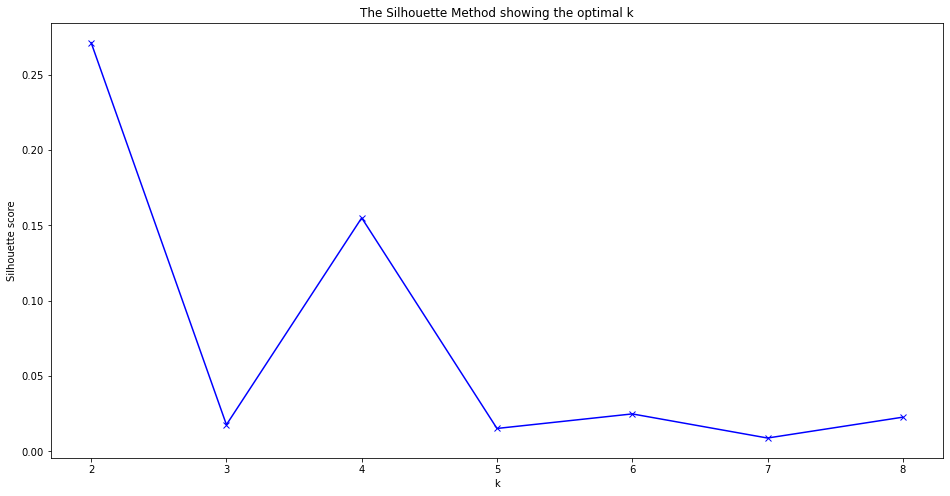

In [44]:
from sklearn.metrics import silhouette_score
three_cities_grouped_clustering = three_cities_grouped.drop('Neighborhood', 1)
three_cities_grouped_clustering = three_cities_grouped_clustering.drop('City', 1)
import matplotlib.pyplot as plt
sil = []
K = range(2,9)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(three_cities_grouped_clustering)
    sil.append(silhouette_score(three_cities_grouped_clustering, kmeanModel.labels_, metric = 'euclidean'))
    
    
plt.figure(figsize=(16,8))
plt.plot(K, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('The Silhouette Method showing the optimal k')
plt.show()

I mentioned before that a high Silhouette Score is desirable. The Silhouette Score reaches its global maximum at the optimal k. This should ideally appear as a peak in the Silhouette Value-versus-k plot.
There is a clear peak at k = 4. Hence, it is optimal.

### Using Elbow Method to find the best K:

This is probably the most well-known method for determining the optimal number of clusters. It is also a bit naive in its approach.I Calculated the Within-Cluster-Sum of Squared Errors (WSS) for different values of k, and chose the k for which WSS becomes first starts to diminish. In the plot of WSS-versus-k, this is visible as an elbow.

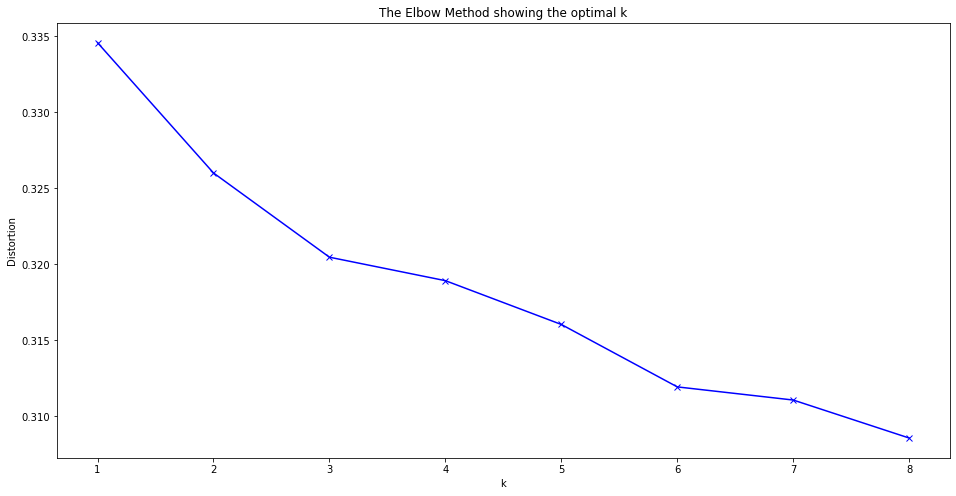

In [48]:
from scipy.spatial.distance import cdist
three_cities_grouped_clustering = three_cities_grouped.drop('Neighborhood', 1)
three_cities_grouped_clustering = three_cities_grouped_clustering.drop('City', 1)
distortions = []
K = range(1,9)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(three_cities_grouped_clustering)
    #centroids = kmeanModel.cluster_centers_
    distortions.append(sum(np.min(cdist(three_cities_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / three_cities_grouped_clustering.shape[0])
    

    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()
    

## Clustering for K=4:

In [49]:
kclusters = 4


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(three_cities_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:30] 

array([2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 3, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2,
       2, 2, 0, 2, 1, 2, 0, 2], dtype=int32)

#### Finding 10 most common venues for each neighborhood:

In [50]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood','City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
three_cities_venues_sorted = pd.DataFrame(columns=columns)
three_cities_venues_sorted['City'] = three_cities_grouped['City']
three_cities_venues_sorted['Neighborhood'] = three_cities_grouped['Neighborhood']

for ind in np.arange(three_cities_grouped.shape[0]):
    three_cities_venues_sorted.iloc[ind, 2:] = return_most_common_venues(three_cities_grouped.iloc[ind, :], num_top_venues)

three_cities_venues_sorted.head()

,Neighborhood,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Toronto,Latin American Restaurant,Skating Rink,Breakfast Spot,Lounge,Clothing Store,Factory,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
1,"Alderwood, Long Branch",Toronto,Pizza Place,Pharmacy,Gym,Coffee Shop,Pub,Sandwich Place,Ethiopian Restaurant,Event Service,Event Space,Farmers Market
2,Allerton,Newyork,Pizza Place,Chinese Restaurant,Deli / Bodega,Supermarket,Spa,Cosmetics Shop,Spanish Restaurant,Check Cashing Service,Martial Arts School,Bakery
3,Annadale,Newyork,Pizza Place,American Restaurant,Deli / Bodega,Diner,Food,Restaurant,Dance Studio,Train Station,Park,Eye Doctor
4,Arden Heights,Newyork,Pharmacy,Coffee Shop,Pizza Place,Bus Stop,Deli / Bodega,Event Space,Exhibit,Eye Doctor,Field,Event Service


#### Attaching cluster Label to our data frame

In [51]:
three_cities_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
combined = pd.merge(combination, three_cities_venues_sorted, on=['Neighborhood','City'])
combined.head()

,Neighborhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wakefield,40.894705,-73.847201,Newyork,0,Pharmacy,Deli / Bodega,Laundromat,Donut Shop,Gas Station,Ice Cream Shop,Sandwich Place,Dessert Shop,Falafel Restaurant,Fast Food Restaurant
1,Co-op City,40.874294,-73.829939,Newyork,0,Bus Station,Accessories Store,Discount Store,Fast Food Restaurant,Grocery Store,Park,Chinese Restaurant,Baseball Field,Bar,Trail
2,Eastchester,40.887556,-73.827806,Newyork,0,Caribbean Restaurant,Bus Station,Deli / Bodega,Diner,Food & Drink Shop,Pizza Place,Donut Shop,Fast Food Restaurant,Automotive Shop,Seafood Restaurant
3,Fieldston,40.895437,-73.905643,Newyork,2,Medical Supply Store,River,Plaza,Zoo Exhibit,Field,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit
4,Riverdale,40.890834,-73.912585,Newyork,3,Park,Home Service,Food Truck,Plaza,Bank,Bus Station,Gym,Moving Target,Playground,Falafel Restaurant


### Exploring each cluster's common venues

#### cluster 0:

In [52]:
combined[combined['Cluster Labels']==0].head()

,Neighborhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wakefield,40.894705,-73.847201,Newyork,0,Pharmacy,Deli / Bodega,Laundromat,Donut Shop,Gas Station,Ice Cream Shop,Sandwich Place,Dessert Shop,Falafel Restaurant,Fast Food Restaurant
1,Co-op City,40.874294,-73.829939,Newyork,0,Bus Station,Accessories Store,Discount Store,Fast Food Restaurant,Grocery Store,Park,Chinese Restaurant,Baseball Field,Bar,Trail
2,Eastchester,40.887556,-73.827806,Newyork,0,Caribbean Restaurant,Bus Station,Deli / Bodega,Diner,Food & Drink Shop,Pizza Place,Donut Shop,Fast Food Restaurant,Automotive Shop,Seafood Restaurant
5,Kingsbridge,40.881687,-73.902818,Newyork,0,Pizza Place,Sandwich Place,Bar,Latin American Restaurant,Bakery,Mexican Restaurant,Pharmacy,Spanish Restaurant,Fried Chicken Joint,Supermarket
6,Marble Hill,40.876551,-73.910660,Newyork,0,Coffee Shop,Gym,Discount Store,Sandwich Place,Deli / Bodega,Donut Shop,Pizza Place,Pharmacy,Diner,Seafood Restaurant


#### Cluster 1:

In [53]:
combined[combined['Cluster Labels']==1].head()

,Neighborhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
45,Edenwald,40.884561,-73.848083,Newyork,1,Chinese Restaurant,Deli / Bodega,Playground,Supermarket,Grocery Store,Farmers Market,Farm,Falafel Restaurant,Factory,Eye Doctor
81,Dyker Heights,40.619219,-74.019314,Newyork,1,Bagel Shop,Burger Joint,Grocery Store,Playground,Golf Course,Field,Ethiopian Restaurant,Event Service,Event Space,Exhibit
185,Holliswood,40.720957,-73.767142,Newyork,1,Fried Chicken Joint,Mobile Phone Shop,Grocery Store,Donut Shop,Playground,Sandwich Place,Ethiopian Restaurant,Event Service,Event Space,Exhibit
228,Graniteville,40.620172,-74.153152,Newyork,1,Boat or Ferry,Grocery Store,Zoo Exhibit,Film Studio,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory
303,Bayswater,40.611322,-73.765968,Newyork,1,Playground,Zoo Exhibit,Filipino Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory


#### Cluster 2:

In [54]:
combined[combined['Cluster Labels']==2].head()

,Neighborhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Fieldston,40.895437,-73.905643,Newyork,2,Medical Supply Store,River,Plaza,Zoo Exhibit,Field,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit
9,Williamsbridge,40.881039,-73.857446,Newyork,2,Nightclub,Bar,Caribbean Restaurant,Soup Place,Filipino Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory
12,City Island,40.847247,-73.786488,Newyork,2,Seafood Restaurant,Boat or Ferry,Park,Thrift / Vintage Store,Italian Restaurant,History Museum,Pharmacy,Harbor / Marina,Bank,Bar
22,Port Morris,40.801664,-73.913221,Newyork,2,Furniture / Home Store,Storage Facility,Donut Shop,Baseball Field,Distillery,Restaurant,Latin American Restaurant,Peruvian Restaurant,Brewery,Field
29,Country Club,40.844246,-73.824099,Newyork,2,Sandwich Place,Flea Market,Playground,Athletics & Sports,Farmers Market,Farm,Falafel Restaurant,Factory,Zoo Exhibit,Fast Food Restaurant


#### Cluster 3:

In [55]:
combined[combined['Cluster Labels']==3].head()

,Neighborhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Riverdale,40.890834,-73.912585,Newyork,3,Park,Home Service,Food Truck,Plaza,Bank,Bus Station,Gym,Moving Target,Playground,Falafel Restaurant
27,Clason Point,40.806551,-73.854144,Newyork,3,Park,Bus Stop,Pool,Boat or Ferry,Grocery Store,South American Restaurant,Convenience Store,Eye Doctor,Factory,Field
151,South Ozone Park,40.668550,-73.809865,Newyork,3,Park,Bar,Food,Hotel,Donut Shop,Sandwich Place,Deli / Bodega,Food Truck,Fast Food Restaurant,Event Space
191,Laurelton,40.667884,-73.740256,Newyork,3,Caribbean Restaurant,Cosmetics Shop,Train Station,Park,Zoo Exhibit,Field,Ethiopian Restaurant,Event Service,Event Space,Exhibit
195,Somerville,40.597711,-73.796648,Newyork,3,Park,Zoo Exhibit,Filipino Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory


#### The number of neighborhoods in each cluster for K=4

In [56]:
num_label=combined.groupby('Cluster Labels').count()
num_label

,Neighborhood,Latitude,Longitude,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,
0,184,184,184,184,184,184,184,184,184,184,184,184,184,184
1,10,10,10,10,10,10,10,10,10,10,10,10,10,10
2,326,326,326,326,326,326,326,326,326,326,326,326,326,326
3,40,40,40,40,40,40,40,40,40,40,40,40,40,40


### Dataframe of neighborhoods and clusters for each city

In [57]:
newyork_cluster=combined[combined['City']=='Newyork']
newyork_cluster.head()

,Neighborhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wakefield,40.894705,-73.847201,Newyork,0,Pharmacy,Deli / Bodega,Laundromat,Donut Shop,Gas Station,Ice Cream Shop,Sandwich Place,Dessert Shop,Falafel Restaurant,Fast Food Restaurant
1,Co-op City,40.874294,-73.829939,Newyork,0,Bus Station,Accessories Store,Discount Store,Fast Food Restaurant,Grocery Store,Park,Chinese Restaurant,Baseball Field,Bar,Trail
2,Eastchester,40.887556,-73.827806,Newyork,0,Caribbean Restaurant,Bus Station,Deli / Bodega,Diner,Food & Drink Shop,Pizza Place,Donut Shop,Fast Food Restaurant,Automotive Shop,Seafood Restaurant
3,Fieldston,40.895437,-73.905643,Newyork,2,Medical Supply Store,River,Plaza,Zoo Exhibit,Field,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit
4,Riverdale,40.890834,-73.912585,Newyork,3,Park,Home Service,Food Truck,Plaza,Bank,Bus Station,Gym,Moving Target,Playground,Falafel Restaurant


In [58]:
toronto_cluster=combined[combined['City']=='Toronto']
toronto_cluster.head()

,Neighborhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
306,Parkwoods,43.753259,-79.329656,Toronto,3,Food & Drink Shop,Park,Zoo Exhibit,Filipino Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor
307,Victoria Village,43.725882,-79.315572,Toronto,0,French Restaurant,Pizza Place,Portuguese Restaurant,Hockey Arena,Coffee Shop,Intersection,Event Service,Event Space,Exhibit,Eye Doctor
308,"Regent Park, Harbourfront",43.654260,-79.360636,Toronto,2,Coffee Shop,Bakery,Park,Pub,Theater,Breakfast Spot,Café,Historic Site,Farmers Market,Mexican Restaurant
309,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,Toronto,2,Clothing Store,Accessories Store,Event Space,Vietnamese Restaurant,Coffee Shop,Boutique,Gift Shop,Furniture / Home Store,Women's Store,Exhibit
310,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Toronto,2,Coffee Shop,Italian Restaurant,Hobby Shop,College Auditorium,Sandwich Place,Bank,Gym,Theater,Park,Chinese Restaurant


In [59]:
london_cluster=combined[combined['City']=='London']
london_cluster.head()

,Neighborhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
406,Bromley0,51.442884,0.031639,London,3,Stables,Park,Zoo Exhibit,Filipino Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor
407,Bromley1,51.440465,0.041526,London,2,Construction & Landscaping,Gym / Fitness Center,Café,Motorcycle Shop,Falafel Restaurant,Field,Fast Food Restaurant,Farmers Market,Farm,Zoo Exhibit
408,Bromley2,51.423211,0.063333,London,2,Italian Restaurant,Indian Restaurant,Café,Grocery Store,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Factory,Filipino Restaurant
409,Bromley3,51.431508,0.076946,London,2,Golf Course,Italian Restaurant,Rental Car Location,Convenience Store,Construction & Landscaping,Mini Golf,Grocery Store,Factory,Farmers Market,Farm
410,Bromley4,51.413598,0.109226,London,2,Hardware Store,Golf Course,Furniture / Home Store,Burger Joint,Zoo Exhibit,Factory,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant


## Visualization:
In this part, I used folium to visualize neigborhoods and their clusters in Toronto,New York and London respectively.(K=4)

In [60]:
map_tor_clusters = folium.Map(location=[tlatitude, tlongitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_cluster['Latitude'], toronto_cluster['Longitude'], toronto_cluster['Neighborhood'], toronto_cluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_tor_clusters)
       
map_tor_clusters

In [61]:
map_new_clusters = folium.Map(location=[nlatitude, nlongitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(newyork_cluster['Latitude'], newyork_cluster['Longitude'], newyork_cluster['Neighborhood'], newyork_cluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_new_clusters)
       
map_new_clusters

In [62]:
map_lon_clusters = folium.Map(location=[51.5074, 0.1278], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_cluster['Latitude'], london_cluster['Longitude'], london_cluster['Neighborhood'], london_cluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_lon_clusters)
       
map_lon_clusters

#### The bar chart, depicting each city with number of neighborhoods in every cluster.

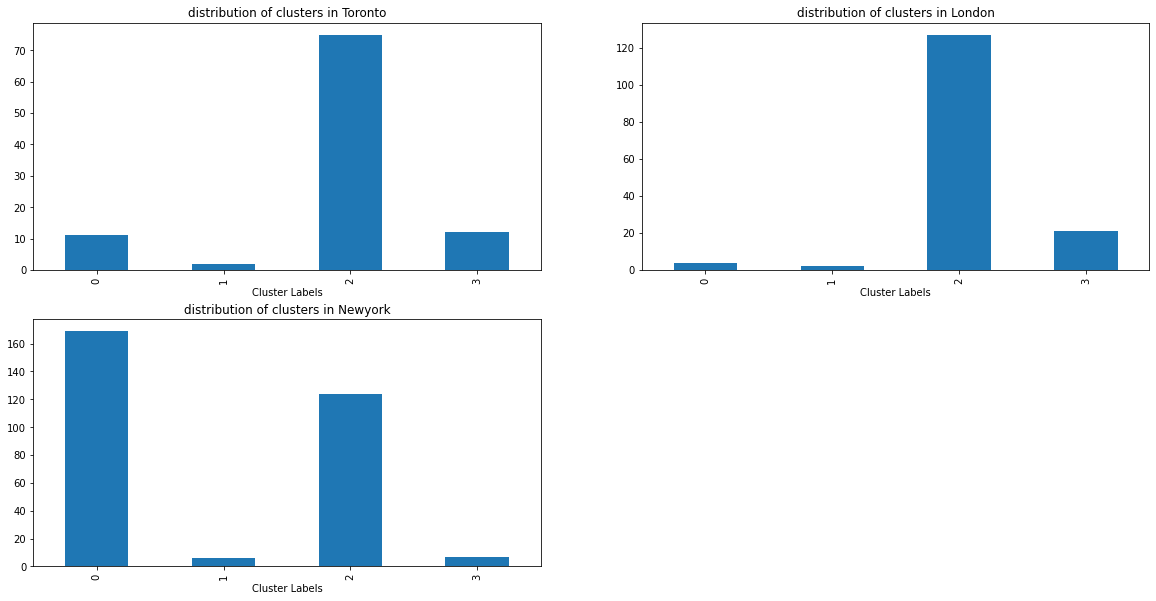

In [63]:
import matplotlib as mpl
import matplotlib.pyplot as plt
barr=combined[['City','Cluster Labels']]
ll1=toronto_cluster[['City','Cluster Labels']].groupby('Cluster Labels').count()
ll2=london_cluster[['City','Cluster Labels']].groupby('Cluster Labels').count()
ll3=newyork_cluster[['City','Cluster Labels']].groupby('Cluster Labels').count()
fig=plt.figure()
ax0=fig.add_subplot(2,2,1)
ax1=fig.add_subplot(2,2,2)
ax2=fig.add_subplot(2,2,3)
#ax3=fig.add_subplot(2,2,4)
ll1.plot(kind='bar',figsize=(20,10),ax=ax0,legend=None)
ll2.plot(kind='bar',figsize=(20,10),ax=ax1,legend=None)
ll3.plot(kind='bar',figsize=(20,10),ax=ax2,legend=None)
ax0.set_title('distribution of clusters in Toronto')
ax1.set_title('distribution of clusters in London')
ax2.set_title('distribution of clusters in Newyork')
plt.show()

In all 3 cities central and downtown neighborhoods mostly belong to cluster 2.
In London and New York outer neighborhoods belong to cluster 0 in contrast to Toronto that has red neighborhoods even in central areas of it. 
London is the only city with all 4 clusters as New York and Toronto do not have any neighborhood in cluster 3.
In London and Toronto most neighborhoods are in cluster 2, while in New York cluster 1 is the dominant one. 
Although the majority of restaurants, bars and pubs are in cluster 2, they can be significantly seen in other clusters as well.
3 cities are located near either sea, river or lake which makes the neighborhoods near these areas similar.
#### All in all, it can be resulted from the number of neighborhoods in each cluster and their location in each city that these three cities are similar to each other in total but London and Toronto are more alike.


## changing the number of clusters to 6

In [57]:
kclusters2 = 6

three_cities_grouped_clustering2 = three_cities_grouped.drop('Neighborhood', 1)
three_cities_grouped_clustering2 = three_cities_grouped_clustering2.drop('City', 1)
three_cities_grouped_clustering2
# run k-means clustering
kmeans2 = KMeans(n_clusters=kclusters2, random_state=0).fit(three_cities_grouped_clustering2)

# check cluster labels generated for each row in the dataframe
kmeans2.labels_[0:30] 

array([4, 1, 1, 1, 1, 2, 1, 4, 4, 1, 4, 5, 4, 3, 2, 4, 4, 0, 0, 1, 1, 4,
       4, 4, 1, 4, 0, 4, 1, 4], dtype=int32)

#### Finding the 10 most common venues in each neighborhood

In [58]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood','City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
three_cities_venues_sorted = pd.DataFrame(columns=columns)
three_cities_venues_sorted['City'] = three_cities_grouped['City']
three_cities_venues_sorted['Neighborhood'] = three_cities_grouped['Neighborhood']

for ind in np.arange(three_cities_grouped.shape[0]):
    three_cities_venues_sorted.iloc[ind, 2:] = return_most_common_venues(three_cities_grouped.iloc[ind, :], num_top_venues)

three_cities_venues_sorted.head()

,Neighborhood,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Toronto,Skating Rink,Breakfast Spot,Lounge,Clothing Store,Latin American Restaurant,Zoo Exhibit,Factory,Fast Food Restaurant,Farmers Market,Farm
1,"Alderwood, Long Branch",Toronto,Pizza Place,Pharmacy,Coffee Shop,Sandwich Place,Pub,Gym,Escape Room,Ethiopian Restaurant,Event Service,Farm
2,Allerton,Newyork,Pizza Place,Spa,Chinese Restaurant,Deli / Bodega,Supermarket,Cosmetics Shop,Check Cashing Service,Martial Arts School,Bakery,Electronics Store
3,Annadale,Newyork,Pizza Place,American Restaurant,Deli / Bodega,Diner,Park,Food,Restaurant,Dance Studio,Train Station,Eye Doctor
4,Arden Heights,Newyork,Deli / Bodega,Pharmacy,Pizza Place,Bus Stop,Coffee Shop,Eye Doctor,Farm,Falafel Restaurant,Factory,Zoo Exhibit


#### Attaching cluster Label to our data frame

In [84]:
three_cities_venues_sorted3=three_cities_venues_sorted
three_cities_venues_sorted3.insert(0, 'Cluster Labels', kmeans2.labels_)
combined2 = pd.merge(combination, three_cities_venues_sorted3, on=['Neighborhood','City'])
combined2.head()


,Neighborhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wakefield,40.894705,-73.847201,Newyork,1,Pharmacy,Ice Cream Shop,Laundromat,Donut Shop,Dessert Shop,Gas Station,Sandwich Place,Deli / Bodega,Factory,Eye Doctor
1,Co-op City,40.874294,-73.829939,Newyork,1,Bus Station,Accessories Store,Discount Store,Fast Food Restaurant,Park,Grocery Store,Chinese Restaurant,Baseball Field,Bar,Trail
2,Eastchester,40.887556,-73.827806,Newyork,1,Caribbean Restaurant,Bus Station,Deli / Bodega,Diner,Fast Food Restaurant,Donut Shop,Pizza Place,Chinese Restaurant,Automotive Shop,Seafood Restaurant
3,Fieldston,40.895437,-73.905643,Newyork,4,Medical Supply Store,River,Plaza,Zoo Exhibit,Field,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit
4,Riverdale,40.890834,-73.912585,Newyork,0,Park,Food Truck,Bus Station,Bank,Playground,Home Service,Moving Target,Gym,Plaza,Event Space


#### The number of neighborhoods in each cluster for K=6

In [60]:
num_label2=combined2.groupby('Cluster Labels').count()
num_label2

,Neighborhood,Latitude,Longitude,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,
0,49,49,49,49,49,49,49,49,49,49,49,49,49,49
1,176,176,176,176,176,176,176,176,176,176,176,176,176,176
2,23,23,23,23,23,23,23,23,23,23,23,23,23,23
3,2,2,2,2,2,2,2,2,2,2,2,2,2,2
4,292,292,292,292,292,292,292,292,292,292,292,292,292,292
5,18,18,18,18,18,18,18,18,18,18,18,18,18,18


## exploring clusters' common venue


### cluster 0

In [77]:
combined2[combined2['Cluster Labels']==0].head()

,Neighborhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Riverdale,40.890834,-73.912585,Newyork,0,Park,Food Truck,Bus Station,Bank,Playground,Home Service,Moving Target,Gym,Plaza,Event Space
7,Woodlawn,40.898273,-73.867315,Newyork,0,Pub,Deli / Bodega,Pizza Place,Bar,Playground,Italian Restaurant,Rental Car Location,Plaza,Donut Shop,Train Station
91,Bergen Beach,40.615150,-73.898556,Newyork,0,Harbor / Marina,Park,Baseball Field,Playground,Hockey Field,Athletics & Sports,Farm,Falafel Restaurant,Factory,Zoo Exhibit
151,South Ozone Park,40.668550,-73.809865,Newyork,0,Park,Bar,Food,Hotel,Donut Shop,Sandwich Place,Deli / Bodega,Food Truck,Fast Food Restaurant,Event Space
191,Laurelton,40.667884,-73.740256,Newyork,0,Caribbean Restaurant,Cosmetics Shop,Train Station,Park,English Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit


### cluster 1

In [78]:
combined2[combined2['Cluster Labels']==1].head()

,Neighborhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wakefield,40.894705,-73.847201,Newyork,1,Pharmacy,Ice Cream Shop,Laundromat,Donut Shop,Dessert Shop,Gas Station,Sandwich Place,Deli / Bodega,Factory,Eye Doctor
1,Co-op City,40.874294,-73.829939,Newyork,1,Bus Station,Accessories Store,Discount Store,Fast Food Restaurant,Park,Grocery Store,Chinese Restaurant,Baseball Field,Bar,Trail
2,Eastchester,40.887556,-73.827806,Newyork,1,Caribbean Restaurant,Bus Station,Deli / Bodega,Diner,Fast Food Restaurant,Donut Shop,Pizza Place,Chinese Restaurant,Automotive Shop,Seafood Restaurant
5,Kingsbridge,40.881687,-73.902818,Newyork,1,Pizza Place,Bar,Sandwich Place,Latin American Restaurant,Bakery,Mexican Restaurant,Liquor Store,Fried Chicken Joint,Spanish Restaurant,Pharmacy
6,Marble Hill,40.876551,-73.910660,Newyork,1,Discount Store,Gym,Sandwich Place,Coffee Shop,Department Store,Tennis Stadium,Seafood Restaurant,Donut Shop,Pharmacy,Pizza Place


### cluster 2:

In [79]:
combined2[combined2['Cluster Labels']==2].head()

,Neighborhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Longwood,40.815099,-73.895788,Newyork,2,Donut Shop,Grocery Store,Latin American Restaurant,Diner,Deli / Bodega,Sandwich Place,Fast Food Restaurant,Exhibit,Eye Doctor,Event Space
45,Edenwald,40.884561,-73.848083,Newyork,2,Chinese Restaurant,Deli / Bodega,Playground,Grocery Store,Supermarket,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Field
74,Canarsie,40.635564,-73.902093,Newyork,2,Gym,Asian Restaurant,Caribbean Restaurant,Grocery Store,Food,Thai Restaurant,Zoo Exhibit,Farm,Falafel Restaurant,Factory
81,Dyker Heights,40.619219,-74.019314,Newyork,2,Bagel Shop,Burger Joint,Grocery Store,Golf Course,Playground,Field,Ethiopian Restaurant,Event Service,Event Space,Exhibit
185,Holliswood,40.720957,-73.767142,Newyork,2,Fried Chicken Joint,Sandwich Place,Grocery Store,Donut Shop,Playground,Mobile Phone Shop,Food,Food Court,Escape Room,Ethiopian Restaurant


### cluster 3:

In [80]:
combined2[combined2['Cluster Labels']==3].head()

,Neighborhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
487,Harrow1,51.612687,-0.402492,London,3,Golf Course,Zoo Exhibit,Field,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor
509,Barking and Dagenham3,51.514693,0.134331,London,3,Golf Course,Zoo Exhibit,Field,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor


### cluster 4

In [81]:
combined2[combined2['Cluster Labels']==4].head()

,Neighborhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Fieldston,40.895437,-73.905643,Newyork,4,Medical Supply Store,River,Plaza,Zoo Exhibit,Field,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit
9,Williamsbridge,40.881039,-73.857446,Newyork,4,Nightclub,Bar,Caribbean Restaurant,Soup Place,Field,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor
12,City Island,40.847247,-73.786488,Newyork,4,Boat or Ferry,Park,Thrift / Vintage Store,Seafood Restaurant,Italian Restaurant,Baseball Field,History Museum,Pharmacy,Harbor / Marina,Bank
22,Port Morris,40.801664,-73.913221,Newyork,4,Furniture / Home Store,Latin American Restaurant,Donut Shop,Distillery,Baseball Field,Restaurant,Peruvian Restaurant,Brewery,Storage Facility,Food Court
29,Country Club,40.844246,-73.824099,Newyork,4,Sandwich Place,Flea Market,Playground,Athletics & Sports,Farmers Market,Farm,Falafel Restaurant,Factory,Zoo Exhibit,Fast Food Restaurant


### cluster 5:

In [82]:
combined2[combined2['Cluster Labels']==5].head()

,Neighborhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Clason Point,40.806551,-73.854144,Newyork,5,Park,Bus Stop,Boat or Ferry,Pool,Convenience Store,Grocery Store,South American Restaurant,Farmers Market,Farm,Falafel Restaurant
195,Somerville,40.597711,-73.796648,Newyork,5,Park,Zoo Exhibit,Filipino Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory
206,Todt Hill,40.597069,-74.111329,Newyork,5,Park,Zoo Exhibit,Filipino Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory
306,Parkwoods,43.753259,-79.329656,Toronto,5,Food & Drink Shop,Park,Zoo Exhibit,Filipino Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor
326,Caledonia-Fairbanks,43.689026,-79.453512,Toronto,5,Park,Pool,Women's Store,Filipino Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor


In [67]:
newyork_cluster2=combined2[combined2['City']=='Newyork']
toronto_cluster2=combined2[combined2['City']=='Toronto']
london_cluster2=combined2[combined2['City']=='London']

## Visualization:
In this part, I used folium to visualize neigborhoods and their clusters in Toronto,New York and London respectively.

In [68]:
map_tor_clusters2 = folium.Map(location=[tlatitude, tlongitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters2)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_cluster2['Latitude'], toronto_cluster2['Longitude'], toronto_cluster2['Neighborhood'], toronto_cluster2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_tor_clusters2)
       
map_tor_clusters2

In [69]:
map_new_clusters2 = folium.Map(location=[nlatitude, nlongitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters2)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(newyork_cluster2['Latitude'], newyork_cluster2['Longitude'], newyork_cluster2['Neighborhood'], newyork_cluster2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_new_clusters2)
       
map_new_clusters2

In [70]:
map_lon_clusters2 = folium.Map(location=[51.5074, -0.08], zoom_start=9.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters2)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_cluster2['Latitude'], london_cluster2['Longitude'], london_cluster2['Neighborhood'], london_cluster2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_lon_clusters2)
       
map_lon_clusters2

#### The bar chart, depicting each city with number of neighborhoods in every cluster.

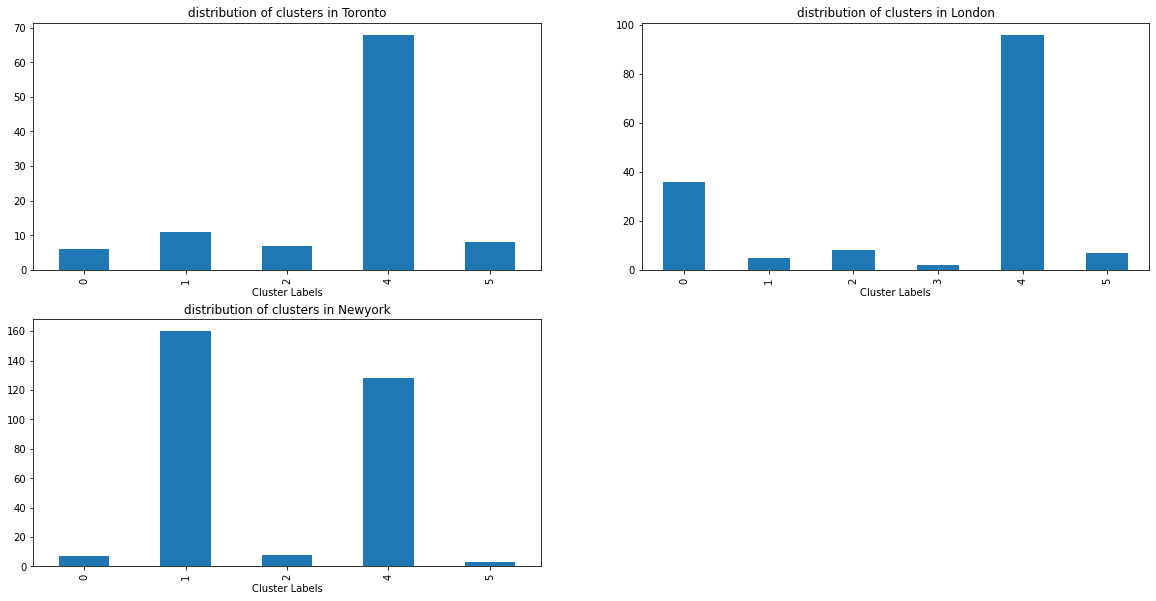

In [73]:
ll12=toronto_cluster2[['City','Cluster Labels']].groupby('Cluster Labels').count()
ll22=london_cluster2[['City','Cluster Labels']].groupby('Cluster Labels').count()
ll32=newyork_cluster2[['City','Cluster Labels']].groupby('Cluster Labels').count()
fig2=plt.figure()
ax02=fig2.add_subplot(2,2,1)
ax12=fig2.add_subplot(2,2,2)
ax22=fig2.add_subplot(2,2,3)
#ax3=fig.add_subplot(2,2,4)
ll12.plot(kind='bar',figsize=(20,10),ax=ax02,legend=None)
ll22.plot(kind='bar',figsize=(20,10),ax=ax12,legend=None)
ll32.plot(kind='bar',figsize=(20,10),ax=ax22,legend=None)
ax02.set_title('distribution of clusters in Toronto')
ax12.set_title('distribution of clusters in London')
ax22.set_title('distribution of clusters in Newyork')
plt.show()

# 5 Discussion and Conclusion
In a fast-moving world, there are many real-life problems or scenarios where data can be used to find solutions to those problems. Like seen in the example above, data was used to cluster neighborhoods in London, Toronto and New York based on the most common venues in their major districts. These cities are the most significant city of their corresponding country and as a result, they are rich in industry, culture and tourism infrastructure.  The results can help a traveler to have a better perspective of each city and its neighborhoods. 
This project would have had better results if there were more data in terms of industrial places within the area, traffic access and allowance of more venues exploration with the Foursquare (limited venues for free calls). Furthermore, this results also could potentially vary if we use some other clustering techniques like DBSCAN. As a final note, all of the above analysis is depended on the adequacy and accuracy of Foursquare data. A more comprehensive analysis and future work would need to incorporate data from other external databases.
